In [26]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

In [28]:
casino = pd.read_csv("Online_casino_DIB.csv")
# Convert the timestamp column to datetime
casino.ReqTimeUTC = pd.to_datetime(casino.ReqTimeUTC)

# Remove timestamps outside the range
casino = casino[casino.ReqTimeUTC <='2020-02-29 00:00:00+00:00'].copy()
# Give new values to df column
casino.TransactionType = casino.TransactionType.map({'LOYALTYCARDDEBIT':'L2D', 'LOYALTYCARDCREDITCL':'L1D', 'LOYALTYCARDCREDIT':'L2W'})
# Filter df by condition 
casino = casino[(casino.TransactionType == "L2D") & (casino.Status=="APPROVED")].reset_index(drop=True)
# and remove single value columns
casino = casino[['AccountIdentifier', 'ReqTimeUTC', 'TransactionAmount']]
# Sort df by column values
casino = casino.sort_values(["AccountIdentifier", "ReqTimeUTC"]).reset_index(drop=True)
# Rename columns
casino.rename(columns = {'AccountIdentifier':'customer', 'ReqTimeUTC':'timest',  'TransactionAmount':'amount'}, inplace=True)
casino.head()

,customer,timest,amount
0,customer1,2019-03-01 17:24:43+00:00,30.0
1,customer1,2019-03-01 19:54:04+00:00,50.0
2,customer1,2019-03-01 22:44:15+00:00,40.0
3,customer1,2019-03-02 02:44:20+00:00,100.0
4,customer1,2019-03-02 18:28:39+00:00,25.0


In [31]:
print(len(casino))
print(len(casino.customer.unique()))


69734
2280


# Cluster analysis

Task:\
Based on the features of the customers, create GROUPS such that:
 - similar customers are close together: Within-group variability is small
 - different customers are far apart: Between-group variablity is large

Input:\
Customer features.

Output:\
One labels for each customer, mapping to the group it was assigned to.

... but we don't have any customer features!
So let's build them. The process is called 
#### FEATURE ENGINEERING.

In [35]:
# How long has the person been a customer for?
# When did the customer purchase last time?
# How many purchases does the customer have?
base_timestamp = pd.to_datetime("2020-03-01 00:00:00+00:00")

retention_ = casino.groupby("customer").agg(
    first_active_in_days = ('timest', lambda x: (base_timestamp - x.dt.floor("d").min()).days),
    last_active_in_days = ('timest', lambda x: (base_timestamp - x.dt.floor("d").max()).days),
    nr_purchases = ('timest', 'count')
    )
retention_ = retention_.reset_index()
retention_.head(3)

,customer,first_active_in_days,last_active_in_days,nr_purchases
0,customer1,366,2,444
1,customer10,364,2,1130
2,customer100,267,4,56


In [43]:
## How much has a customer spent since firstly active?
## How much different are the amounts the customer spent?
overall_spent = casino.groupby("customer").agg({'amount': ['sum', 'std']}).reset_index()
overall_spent.columns = overall_spent.columns.droplevel(0)
overall_spent.rename(columns={"": "customer"}, inplace=True)
overall_spent.head(3)

,customer,sum,std
0,customer1,34010.0,37.678533
1,customer10,32089.0,13.940103
2,customer100,1639.0,9.195831


In [50]:
# How much does the user spend on average every month
casino['y_month'] = casino.timest.dt.to_period('M')
monthly_expenditure = casino.groupby(['customer', 'y_month'])['amount'].sum().reset_index()

monthly_average_spent = monthly_expenditure.groupby('customer')['amount'].mean().reset_index()
monthly_average_spent.rename(columns={'amount': 'm_avg_spent'}, inplace=True)
monthly_average_spent

C:\Users\user\AppData\Local\Temp\ipykernel_25860\241721698.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  casino['y_month'] = casino.timest.dt.to_period('M')


,customer,m_avg_spent
0,customer1,2834.166667
1,customer10,2674.083333
2,customer100,273.166667
3,customer1000,200.000000
4,customer1001,98.428571
...,...,...
2275,customer995,69.700000
2276,customer996,25.000000
2277,customer997,50.000000
2278,customer998,50.000000


In [51]:
overall_spent = overall_spent.set_index("customer")
monthly_average_spent = monthly_average_spent.set_index("customer")
retention_= retention_.set_index("customer")

In [78]:
customer_data = overall_spent.join([monthly_average_spent, retention_]).reset_index()
customer_data

,customer,sum,std,m_avg_spent,first_active_in_days,last_active_in_days,nr_purchases
0,customer1,34010.0,37.678533,2834.166667,366,2,444
1,customer10,32089.0,13.940103,2674.083333,364,2,1130
2,customer100,1639.0,9.195831,273.166667,267,4,56
3,customer1000,200.0,0.000000,200.000000,300,300,2
4,customer1001,689.0,13.769130,98.428571,225,21,23
...,...,...,...,...,...,...,...
2275,customer995,348.5,19.800042,69.700000,304,2,6
2276,customer996,50.0,7.637626,25.000000,353,170,3
2277,customer997,50.0,NaN,50.000000,161,161,1
2278,customer998,50.0,0.000000,50.000000,113,113,2


In [80]:
customer_data.isna().sum()
# Fill with 0
customer_data.loc[customer_data["std"].isna(), "std"] = 0.001
customer_data.loc[customer_data["std"] == 0] = 0.001
customer_data

,customer,sum,std,m_avg_spent,first_active_in_days,last_active_in_days,nr_purchases
0,customer1,34010.000,37.678533,2834.166667,366.000,2.000,444.000
1,customer10,32089.000,13.940103,2674.083333,364.000,2.000,1130.000
2,customer100,1639.000,9.195831,273.166667,267.000,4.000,56.000
3,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001
4,customer1001,689.000,13.769130,98.428571,225.000,21.000,23.000
...,...,...,...,...,...,...,...
2275,customer995,348.500,19.800042,69.700000,304.000,2.000,6.000
2276,customer996,50.000,7.637626,25.000000,353.000,170.000,3.000
2277,customer997,50.000,0.001000,50.000000,161.000,161.000,1.000
2278,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001


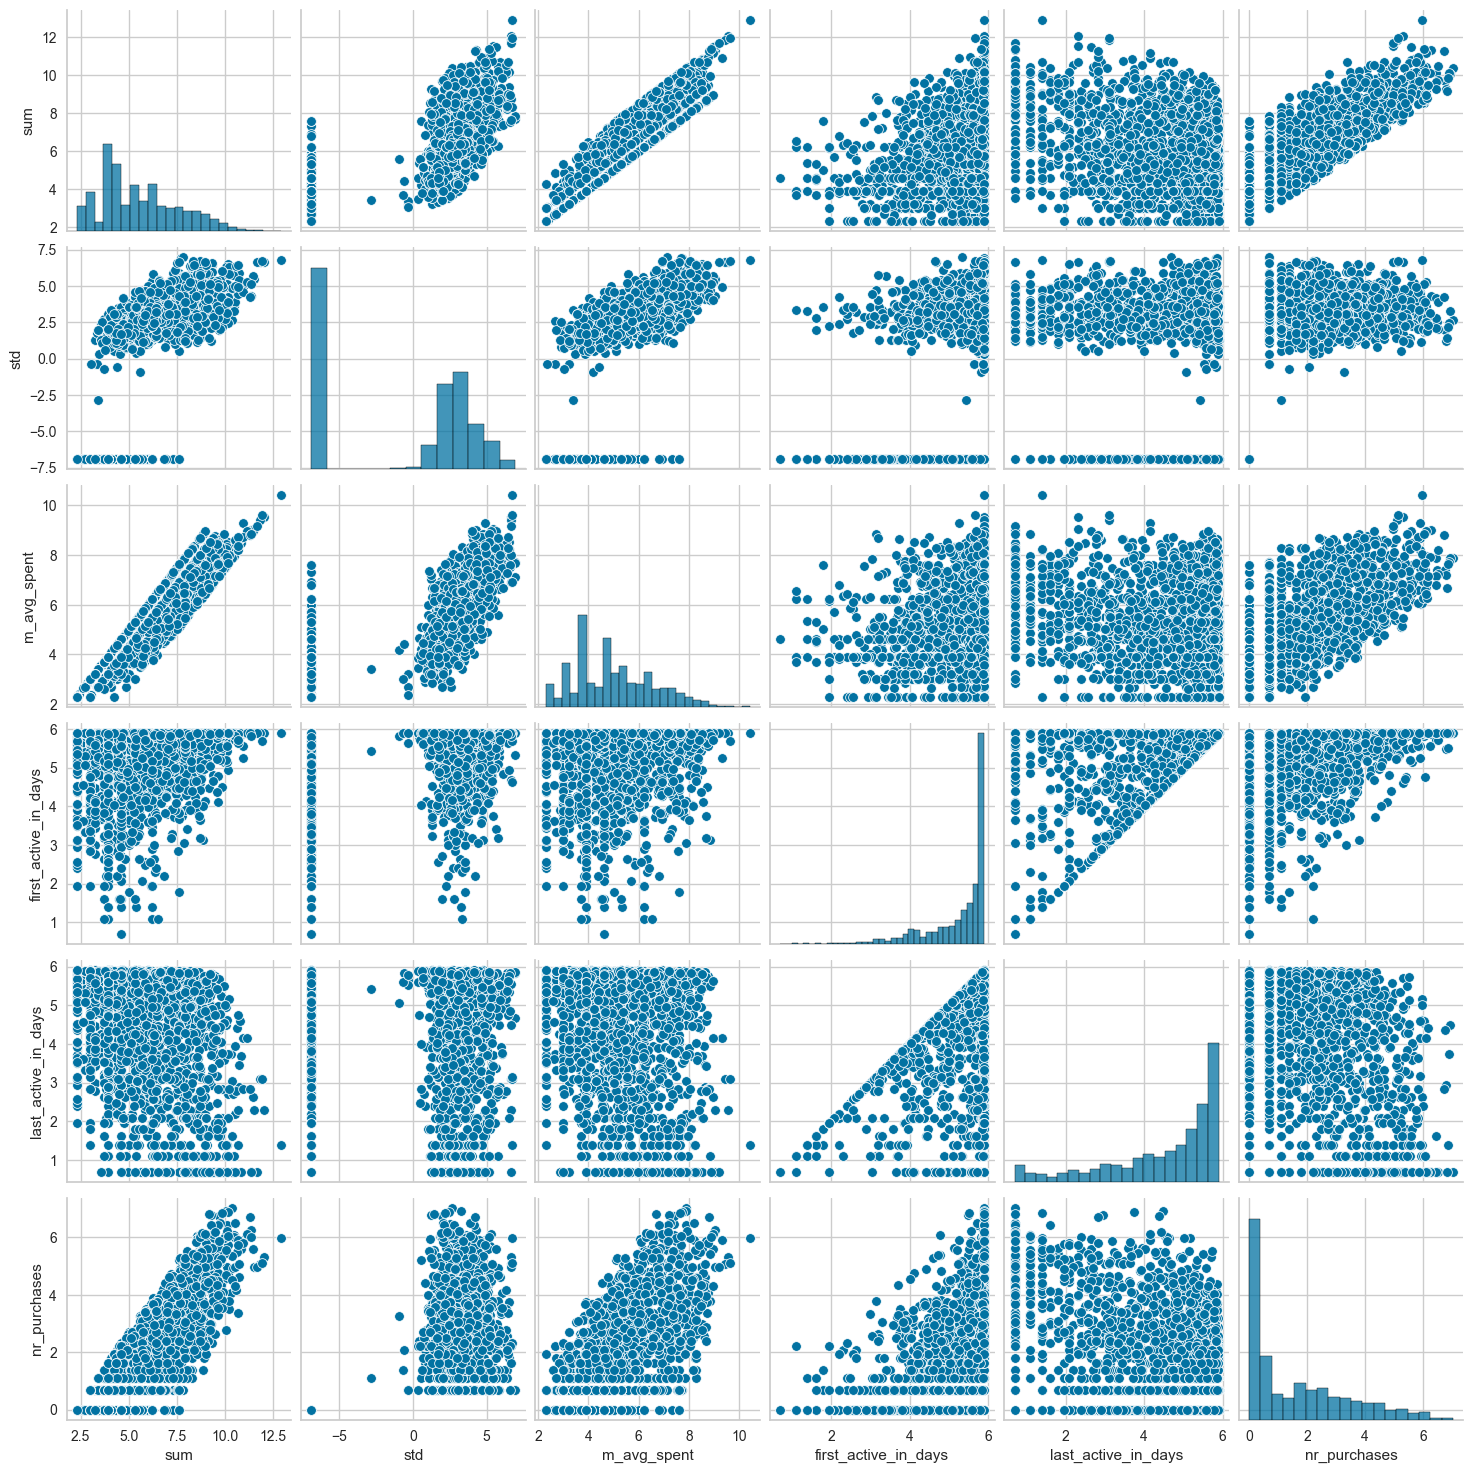

In [66]:
sns.pairplot(X_std)

In [81]:
X = customer_data[['sum', 'std', 'm_avg_spent', 'first_active_in_days','last_active_in_days', 'nr_purchases']]

#
X_std = np.log(X)

[208369.09872861882, 79750.95861767113, 18815.592449415755, 12416.469508679917, 10700.040196740156, 9724.490775625087]


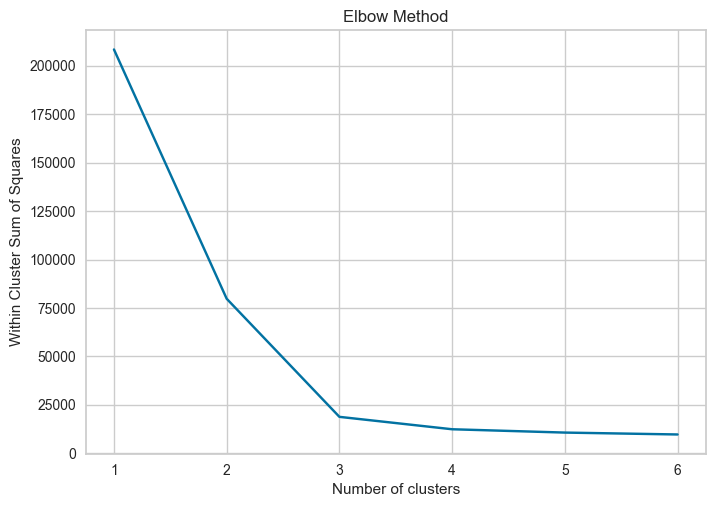

In [89]:
cluster = [1,2,3,4,5,6]
wcss_ls = []

for i in cluster:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X_std)
    wcss = kmeans.inertia_
    wcss_ls.append(wcss)
print(wcss_ls)
plt.plot(cluster, wcss_ls)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()


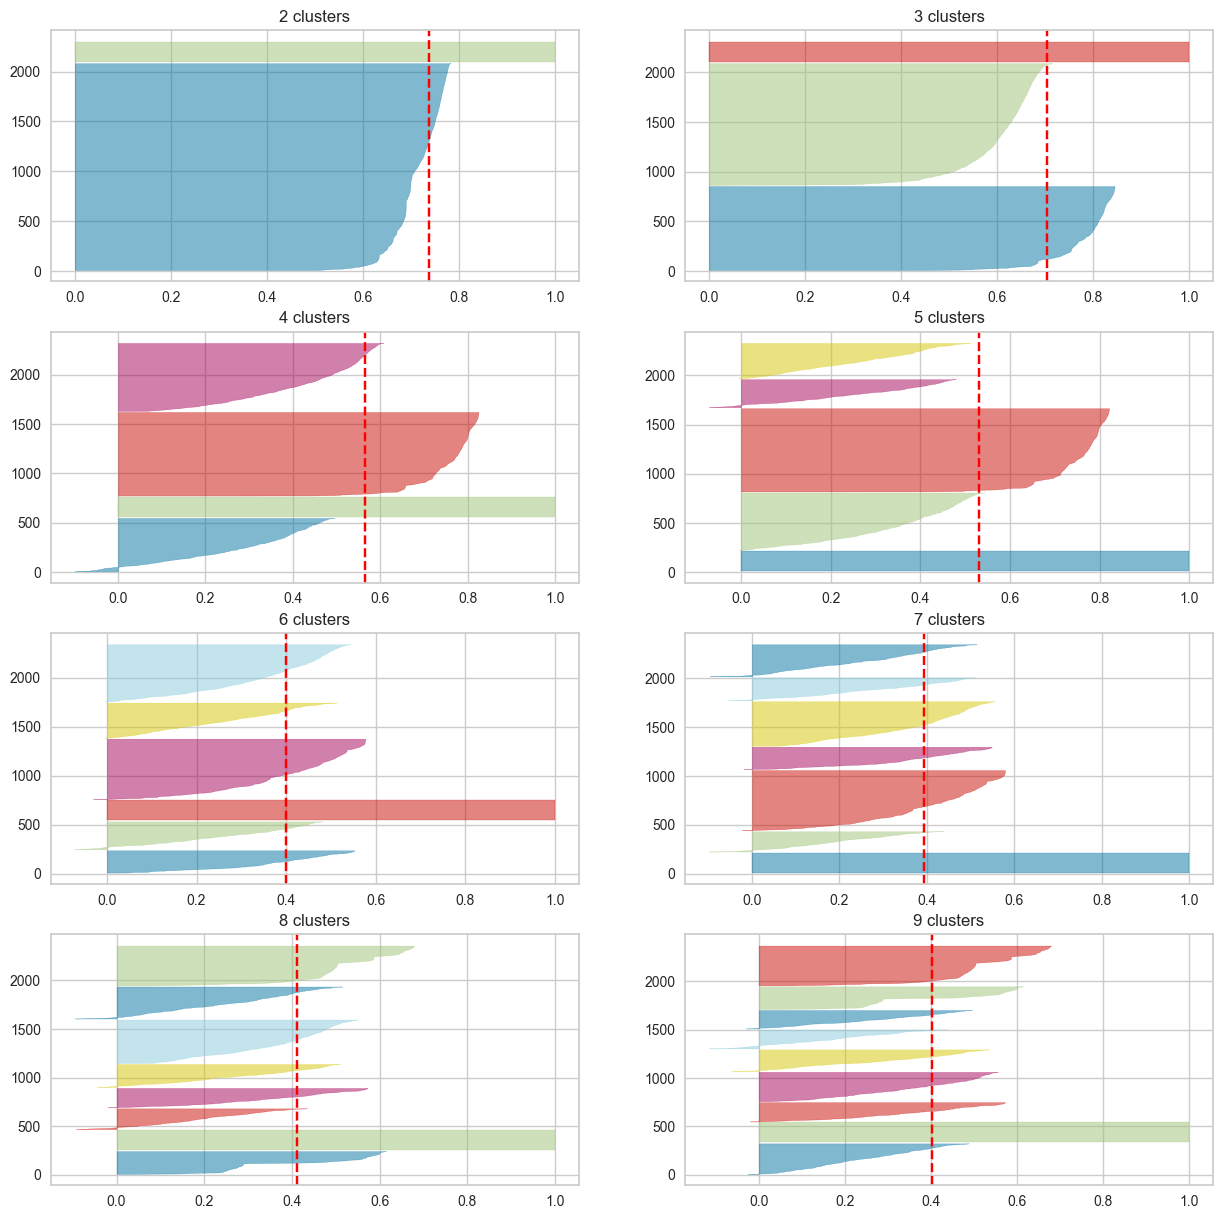

In [90]:
fig, ax = plt.subplots(4, 2, figsize=(15,15))

for i in [2, 3, 4, 5, 6,7,8,9]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_std)
    ax[q-1][mod].set_title(f"{i} clusters")

In [85]:
cluster_model = KMeans(n_clusters=3)
kmeans = cluster_model.fit(X_std)
silhouette_score(X_std, labels = kmeans.labels_)

np.float64(0.7044985731905409)

In [86]:
customer_data['group'] = kmeans.labels_
customer_data

,customer,sum,std,m_avg_spent,first_active_in_days,last_active_in_days,nr_purchases,group
0,customer1,34010.000,37.678533,2834.166667,366.000,2.000,444.000,0
1,customer10,32089.000,13.940103,2674.083333,364.000,2.000,1130.000,0
2,customer100,1639.000,9.195831,273.166667,267.000,4.000,56.000,0
3,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001,1
4,customer1001,689.000,13.769130,98.428571,225.000,21.000,23.000,0
...,...,...,...,...,...,...,...,...
2275,customer995,348.500,19.800042,69.700000,304.000,2.000,6.000,0
2276,customer996,50.000,7.637626,25.000000,353.000,170.000,3.000,0
2277,customer997,50.000,0.001000,50.000000,161.000,161.000,1.000,2
2278,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001,1


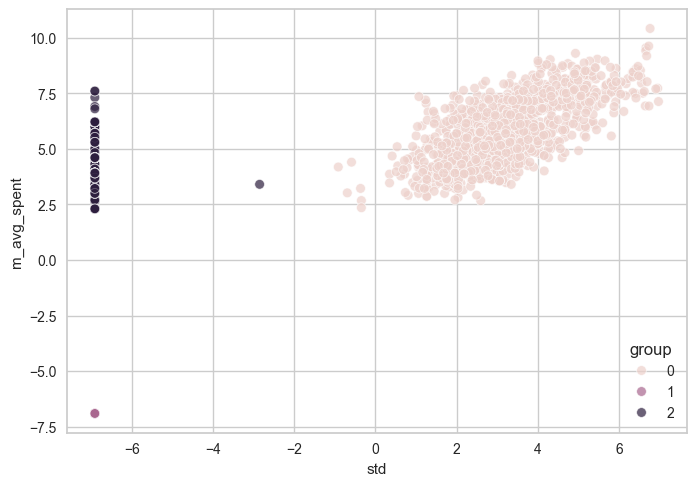

In [87]:
fig, ax = plt.subplots()
sns.scatterplot(X_std, x = "std", y = "m_avg_spent", hue=customer_data['group'], alpha=0.7)
plt.show()

[0, 7, 54, 403, 2980, 22026, 162754]
[0, np.float64(0.02), np.float64(0.14), np.float64(1.0), np.float64(7.39), np.float64(54.6), np.float64(403.43)]


C:\Users\user\AppData\Local\Temp\ipykernel_25860\2862972943.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x)
C:\Users\user\AppData\Local\Temp\ipykernel_25860\2862972943.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y)


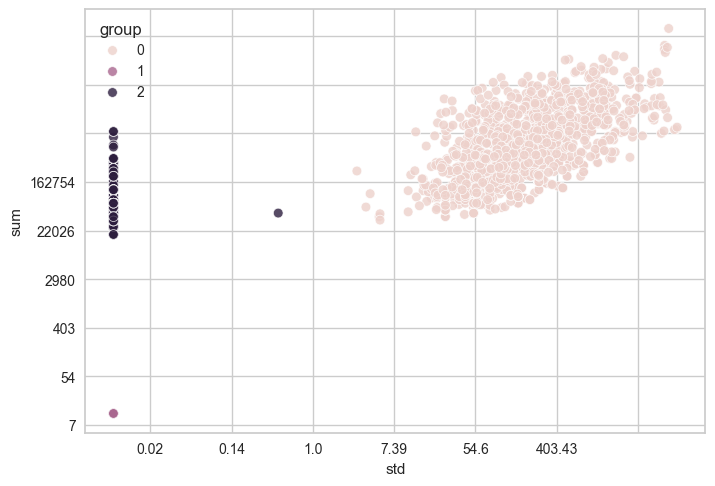

In [88]:
fig, ax = plt.subplots()
sns.scatterplot(X_std, x = "std", y = "sum", hue=customer_data['group'], alpha=0.8)
# sns.scatterplot(X_std, x = "last_active_in_days", y = "m_avg_spent", hue=customer_data['group'], alpha=0.7)

y = [0]
for i in np.arange(2,14,2):
    nr_int = int(np.exp(i))
    y.append(nr_int)
print(y)

x = [0]
for i in range(-4,7,2):
    nr_int = round(np.exp(i),2)
    x.append(nr_int)
print(x)
ax.set_xticklabels(x)
ax.set_yticklabels(y)
plt.show()